In [4]:
import pandas as pd

# Load CSV
df = pd.read_csv("../data/Salary_Data.csv")
print(df.head())

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


In [5]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6704 entries, 0 to 6703
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6702 non-null   float64
 1   Gender               6702 non-null   object 
 2   Education Level      6701 non-null   object 
 3   Job Title            6702 non-null   object 
 4   Years of Experience  6701 non-null   float64
 5   Salary               6699 non-null   float64
dtypes: float64(3), object(3)
memory usage: 314.4+ KB
None
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


In [6]:
# Drop rows with any missing values
df_clean = df.dropna()

print("After dropping missing values:", df_clean.shape)


After dropping missing values: (6698, 6)


In [7]:
df_encoded = pd.get_dummies(df_clean, columns=["Gender", "Education Level", "Job Title"], drop_first=True)


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_encoded[["Age", "Years of Experience"]] = scaler.fit_transform(df_encoded[["Age", "Years of Experience"]])


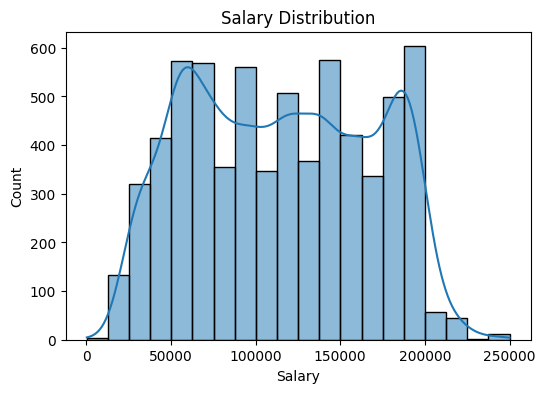

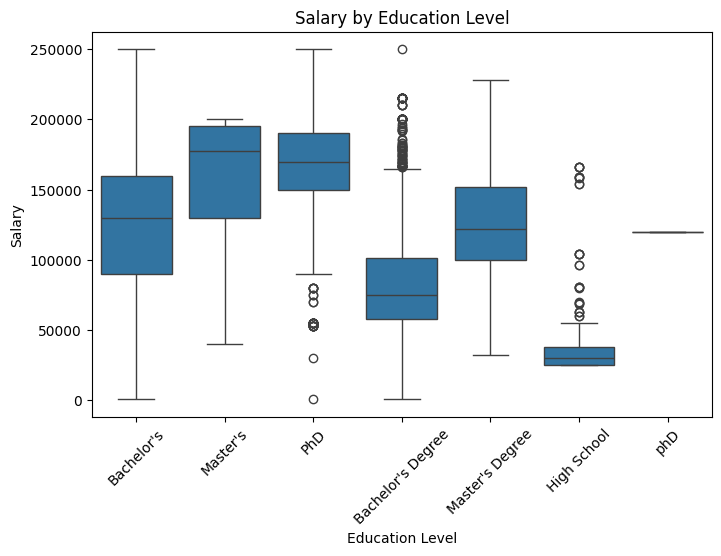

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Salary Distribution
plt.figure(figsize=(6,4))
sns.histplot(df_clean['Salary'], bins=20, kde=True)
plt.title("Salary Distribution")
plt.xlabel("Salary")
plt.savefig("salary_distribution.png")
plt.show()

# Salary vs Education Level
plt.figure(figsize=(8,5))
sns.boxplot(x='Education Level', y='Salary', data=df_clean)
plt.xticks(rotation=45)
plt.title("Salary by Education Level")
plt.savefig("salary_vs_education.png")
plt.show()



In [13]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Apply to numeric columns
for col in ['Salary', 'Age', 'Years of Experience']:
    df_clean = remove_outliers_iqr(df_clean, col)

print(f"Shape after outlier removal: {df_clean.shape}")


Shape after outlier removal: (6550, 6)


In [15]:
from sklearn.model_selection import train_test_split

# Features and target
X = df.drop("Salary", axis=1)
y = df["Salary"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# Define columns
num_cols = ["Age", "Years of Experience"]
cat_cols = ["Gender", "Education Level", "Job Title"]

# Preprocessing steps
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer

# Update preprocessor to handle missing values
num_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_imputer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_with_impute = ColumnTransformer([
    ("num", num_imputer, num_cols),
    ("cat", cat_imputer, cat_cols)
])

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Fit models
for name, model in models.items():
    pipeline = Pipeline([
        ("preprocess", preprocessor_with_impute),
        ("model", model)
    ])
    pipeline.fit(X_train, y_train)
    score = pipeline.score(X_test, y_test)
    print(f"{name} R² Score: {score:.3f}")


ValueError: Input y contains NaN.